In [ ]:
# we have done transfer learning feature extractiion and fine-tuning, now we will do scaling up

## loading data

In [1]:
# creating helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-04 13:40:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-04 13:40:00 (50.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# importing series of helper function for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2021-10-04 13:40:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   200MB/s    in 7.8s    

2021-10-04 13:40:11 (198 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food

## data preprocessing

In [4]:
# setup data
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


 train big dog model with transfer learning on 10% of data

here are the steps we will follow:
- create a ModelCheckpoint callbacks
- create data augumentation layer ot build data augumentation into the mmodel
- Build headless (no top layer) functional EfficientB0 backboned model
- compile our model
- Feature extract for 5 full passes i.e. epochs

In [5]:
# create checkpoint callbacks
checkpoint_path='101_food_classes_10_percent_data_model_checkpoint'
checkpoint_callbacks= tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True)

## data augumentation

In [6]:
# create data augumentation llayer to incoperate its right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# setup data augumentation

data_augumentation = Sequential([
                                 preprocessing.RandomFlip('horizontal'),
                                 preprocessing.RandomRotation(0.2),
                                 preprocessing.RandomHeight(0.2),
                                 preprocessing.RandomWidth(0.2),
                                 preprocessing.RandomZoom(0.2),
                                 # preprocessing.Rescaling(0.2), # rescaling of input images  between 0-1 and is not required in efficientNet
], name='data_augumentation')

## creating model

In [7]:
# build headless B0 efficient 
# setup the base model and freeze its layer (this will extract feature)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
input=layers.Input(shape=(224,224,3),name='input_layer')
x=data_augumentation(input)
x= base_model(x, training=False)
x= layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)

output= layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model= tf.keras.Model(input, output)
                                                                                                            

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augumentation (Sequenti (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


- we have created transfer learning feature extraction model.

## training

In [12]:
# compiling our model.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

epoch=5
# fiting our model
history_all_classes_10_percent= model.fit(train_data_all_10_percent,
                     epochs=epoch,
                     validation_data=test_data,
                     validation_steps=int(0.15*len(test_data)),
                     callbacks=[checkpoint_callbacks])

Epoch 1/5
237/237 [==============================] - 123s 485ms/step - loss: 3.4726 - accuracy: 0.2473 - val_loss: 2.5350 - val_accuracy: 0.4341
Epoch 2/5
237/237 [==============================] - 93s 389ms/step - loss: 2.3506 - accuracy: 0.4648 - val_loss: 2.1758 - val_accuracy: 0.4730
Epoch 3/5
237/237 [==============================] - 85s 355ms/step - loss: 1.9767 - accuracy: 0.5253 - val_loss: 2.0169 - val_accuracy: 0.4952
Epoch 4/5
237/237 [==============================] - 79s 331ms/step - loss: 1.7588 - accuracy: 0.5720 - val_loss: 1.9816 - val_accuracy: 0.4889
Epoch 5/5
237/237 [==============================] - 76s 320ms/step - loss: 1.6049 - accuracy: 0.6050 - val_loss: 1.9527 - val_accuracy: 0.4939


In [13]:
# evaluate on whole data set
fine_tuning_results=model.evaluate(test_data) 
fine_tuning_results

790/790 [==============================] - 101s 127ms/step - loss: 1.7273 - accuracy: 0.5485


[1.7272831201553345, 0.5485148429870605]

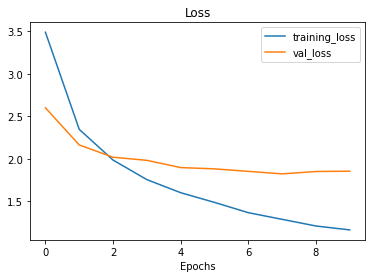

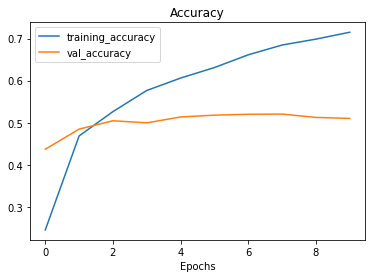

In [ ]:
# plotting curves
plot_loss_curves(hostory_1)

- when training loss is decreasing and accuracy is incraesing while val_loss and val_acc is somewhat constant, this means that our model is learning too well and isn't generalising to unseen data.

- two curves should be simmilar in nature.
- if mot it may suggest that model is overfitting (perforing too well on training data and not generalsing on unseen data)

In [ ]:
# unfreezing layers
base_model.trainable=True

# Refreezzing layers
for layers in base_model.layers[:-5]:
  layers.trainable=False

In [ ]:
# which layers in model are trainable
for layers in model.layers:
  print(layers.name, layers.trainable)

input_layer True
data_augumentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# which layers are trainable in base_model
for layer_number,layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

## fine-tuning

- when we are unfreezing layers we can change optimizer learning rate and we need to reduce the laerning rate.

In [14]:
# fine-tuning for 10 more epoch
fine_tune_epoch=10


# re-compiling (it is advised to lower the learning rate by 10x)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])


#fine-tune our model
history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epoch,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 76s 292ms/step - loss: 1.4365 - accuracy: 0.6613 - val_loss: 1.9411 - val_accuracy: 0.5019
Epoch 6/10
237/237 [==============================] - 70s 292ms/step - loss: 1.4110 - accuracy: 0.6683 - val_loss: 1.9308 - val_accuracy: 0.5024
Epoch 7/10
237/237 [==============================] - 66s 276ms/step - loss: 1.3978 - accuracy: 0.6683 - val_loss: 1.9281 - val_accuracy: 0.5040
Epoch 8/10
237/237 [==============================] - 67s 282ms/step - loss: 1.3787 - accuracy: 0.6714 - val_loss: 1.9099 - val_accuracy: 0.5087
Epoch 9/10
237/237 [==============================] - 64s 269ms/step - loss: 1.3675 - accuracy: 0.6717 - val_loss: 1.9219 - val_accuracy: 0.5037
Epoch 10/10
237/237 [==============================] - 62s 261ms/step - loss: 1.3502 - accuracy: 0.6758 - val_loss: 1.9114 - val_accuracy: 0.5066


In [15]:
all_classes_10_percent_fine_tune_results= model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 100s 127ms/step - loss: 1.6652 - accuracy: 0.5648


[1.6652114391326904, 0.5648316740989685]

## comparing history of feature extraction with fine-tune model 

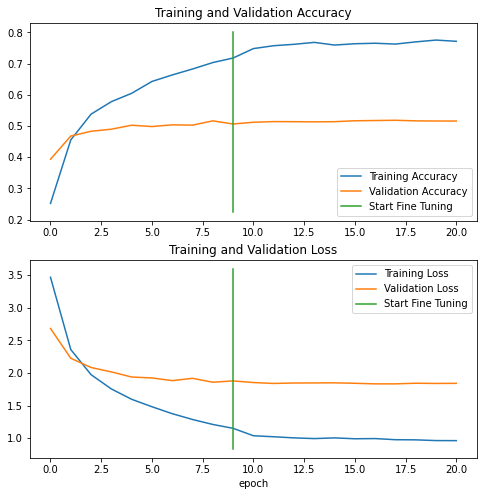

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=10) # epoch used in feature extractor model 

## saving and loading 
- by saving our model we can use it in exteral application

In [ ]:
# saving model
model.save('/content/drive/MyDrive/stonepelter')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/stonepelter/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [8]:
# loading model
loaded_model=tf.keras.models.load_model('/content/drive/MyDrive/tf_dev')

In [16]:
# evaluating loaded model and comparing performance to pre-saved model
loaded_model_results=loaded_model.evaluate(test_data)
print(loaded_model_results)

# pre-saved results
print(all_classes_10_percent_fine_tune_results)


790/790 [==============================] - 102s 129ms/step - loss: 1.6123 - accuracy: 0.5716
[1.612335205078125, 0.5715643763542175]
[1.6652114391326904, 0.5648316740989685]


# prediction
- evaluating the performance of model across all different class
- make prediction , visualize and then find ehich prediction are most wrong.


In [17]:
import tensorflow

# downloading pre-trained model, that was trained earlier, so all perdiction are similar
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-10-04 14:11:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 142.250.152.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   144MB/s    in 0.3s    

2021-10-04 14:11:08 (144 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [18]:
# laoding saved model
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [19]:
model=tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 104s 130ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [20]:
# making prediction with our model
pred_prob=model.predict(test_data, verbose=1)

790/790 [==============================] - 88s 110ms/step


In [21]:
# how many predictions are there
print(len(pred_prob))
# or we can also check
print(pred_prob.shape)

25250
(25250, 101)


In [ ]:
# lets see first 10 prediction
pred_prob[:10]

array([[5.95416836e-02, 3.57428826e-06, 4.13775034e-02, ...,
        1.41388878e-09, 8.35322935e-05, 3.08979349e-03],
       [9.64016914e-01, 1.37532485e-09, 8.47794174e-04, ...,
        5.42856069e-05, 7.83629585e-12, 9.84658577e-10],
       [9.59259272e-01, 3.25341025e-05, 1.48668792e-03, ...,
        7.18893887e-07, 5.43998908e-07, 4.02755286e-05],
       ...,
       [4.73130912e-01, 1.29313591e-07, 1.48055470e-03, ...,
        5.97499078e-04, 6.69691726e-05, 2.34695253e-05],
       [4.45719361e-02, 4.72653340e-07, 1.22584514e-01, ...,
        6.34983689e-06, 7.53184941e-06, 3.67787899e-03],
       [7.24386990e-01, 1.92499949e-09, 5.23111012e-05, ...,
        1.22914580e-03, 1.57930802e-09, 9.63963175e-05]], dtype=float32)

In [ ]:
# lets see fiirst prediction prob look like
pred_prob[0], len(pred_prob[0]), sum(pred_prob[0]) # sum should be equal to 1 as they are prob. 

(array([5.95416836e-02, 3.57428826e-06, 4.13775034e-02, 1.06607523e-09,
        8.16161005e-09, 8.66415917e-09, 8.09286178e-07, 8.56529311e-07,
        1.98594207e-05, 8.09792596e-07, 3.17283311e-09, 9.86754685e-07,
        2.85326882e-04, 7.80504827e-10, 7.42311066e-04, 3.89169145e-05,
        6.47421211e-06, 2.49777895e-06, 3.78914010e-05, 2.06786510e-07,
        1.55386806e-05, 8.15082956e-07, 2.62308754e-06, 2.00108815e-07,
        8.38293261e-07, 5.42168846e-06, 3.73914031e-06, 1.31505757e-08,
        2.77616247e-03, 2.80520071e-05, 6.85631552e-10, 2.55751092e-05,
        1.66892220e-04, 7.64089902e-10, 4.04536608e-04, 1.31508768e-08,
        1.79577773e-06, 1.44484000e-06, 2.30629742e-02, 8.24686140e-07,
        8.53668610e-07, 1.71385364e-06, 7.05265393e-06, 1.84022948e-08,
        2.85536601e-07, 7.94853077e-06, 2.06820914e-06, 1.85254066e-07,
        3.36205197e-08, 3.15226847e-04, 1.04110459e-05, 8.54501081e-07,
        8.47418129e-01, 1.05555300e-05, 4.40947218e-07, 3.740437

In [22]:
# our model output a prediction prob array for each sample passed to predict method
print(f'number of pred prob for sample 0: {len(pred_prob[0])}')
print(f' sample 0 pred prob looks like: {pred_prob[0]}')
print(f'the class with highest predicted prob for sample 0: {pred_prob[0].argmax()}')

number of pred prob for sample 0: 101
 sample 0 pred prob looks like: [5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 1.0569768e-06 2.1293156e-06
 3.7636

In [23]:
test_data.class_names[pred_prob[0].argmax()]

'gyoza'

In [24]:
pred_classes =pred_prob.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

 we got the prediction we need to compare them with original label 

In [25]:
# to get test data labels we need to unravel our test data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #currently test labels are one-hot endcoder

y_labels[:10] # look at first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# howmany y_labels are there
len(y_labels)

25250

- evaluating our models prediction array in same order as our test labels array to find accuracy score
  - Accuracy
  - precision : high precision lead to less False positive (model predict 1 when it should predict 0)
  - recall : high precision lead to less False negative (model predict 0 when it should predict 1)
  - F1 score : combination of precision and recall
  - confusion metrics

In [26]:
# tryingh sklearn accuracy score function.
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

sklearn_accuracy

0.6077623762376237

In [ ]:
results_downloaded_model

[1.802719235420227, 0.6077623963356018]

- results_downloaded_model and accuracy is somewhat similar

In [ ]:
# does the mrtrics come close to our model evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

### making confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [33]:
# get a  list of class_names
class_names=test_data.class_names

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

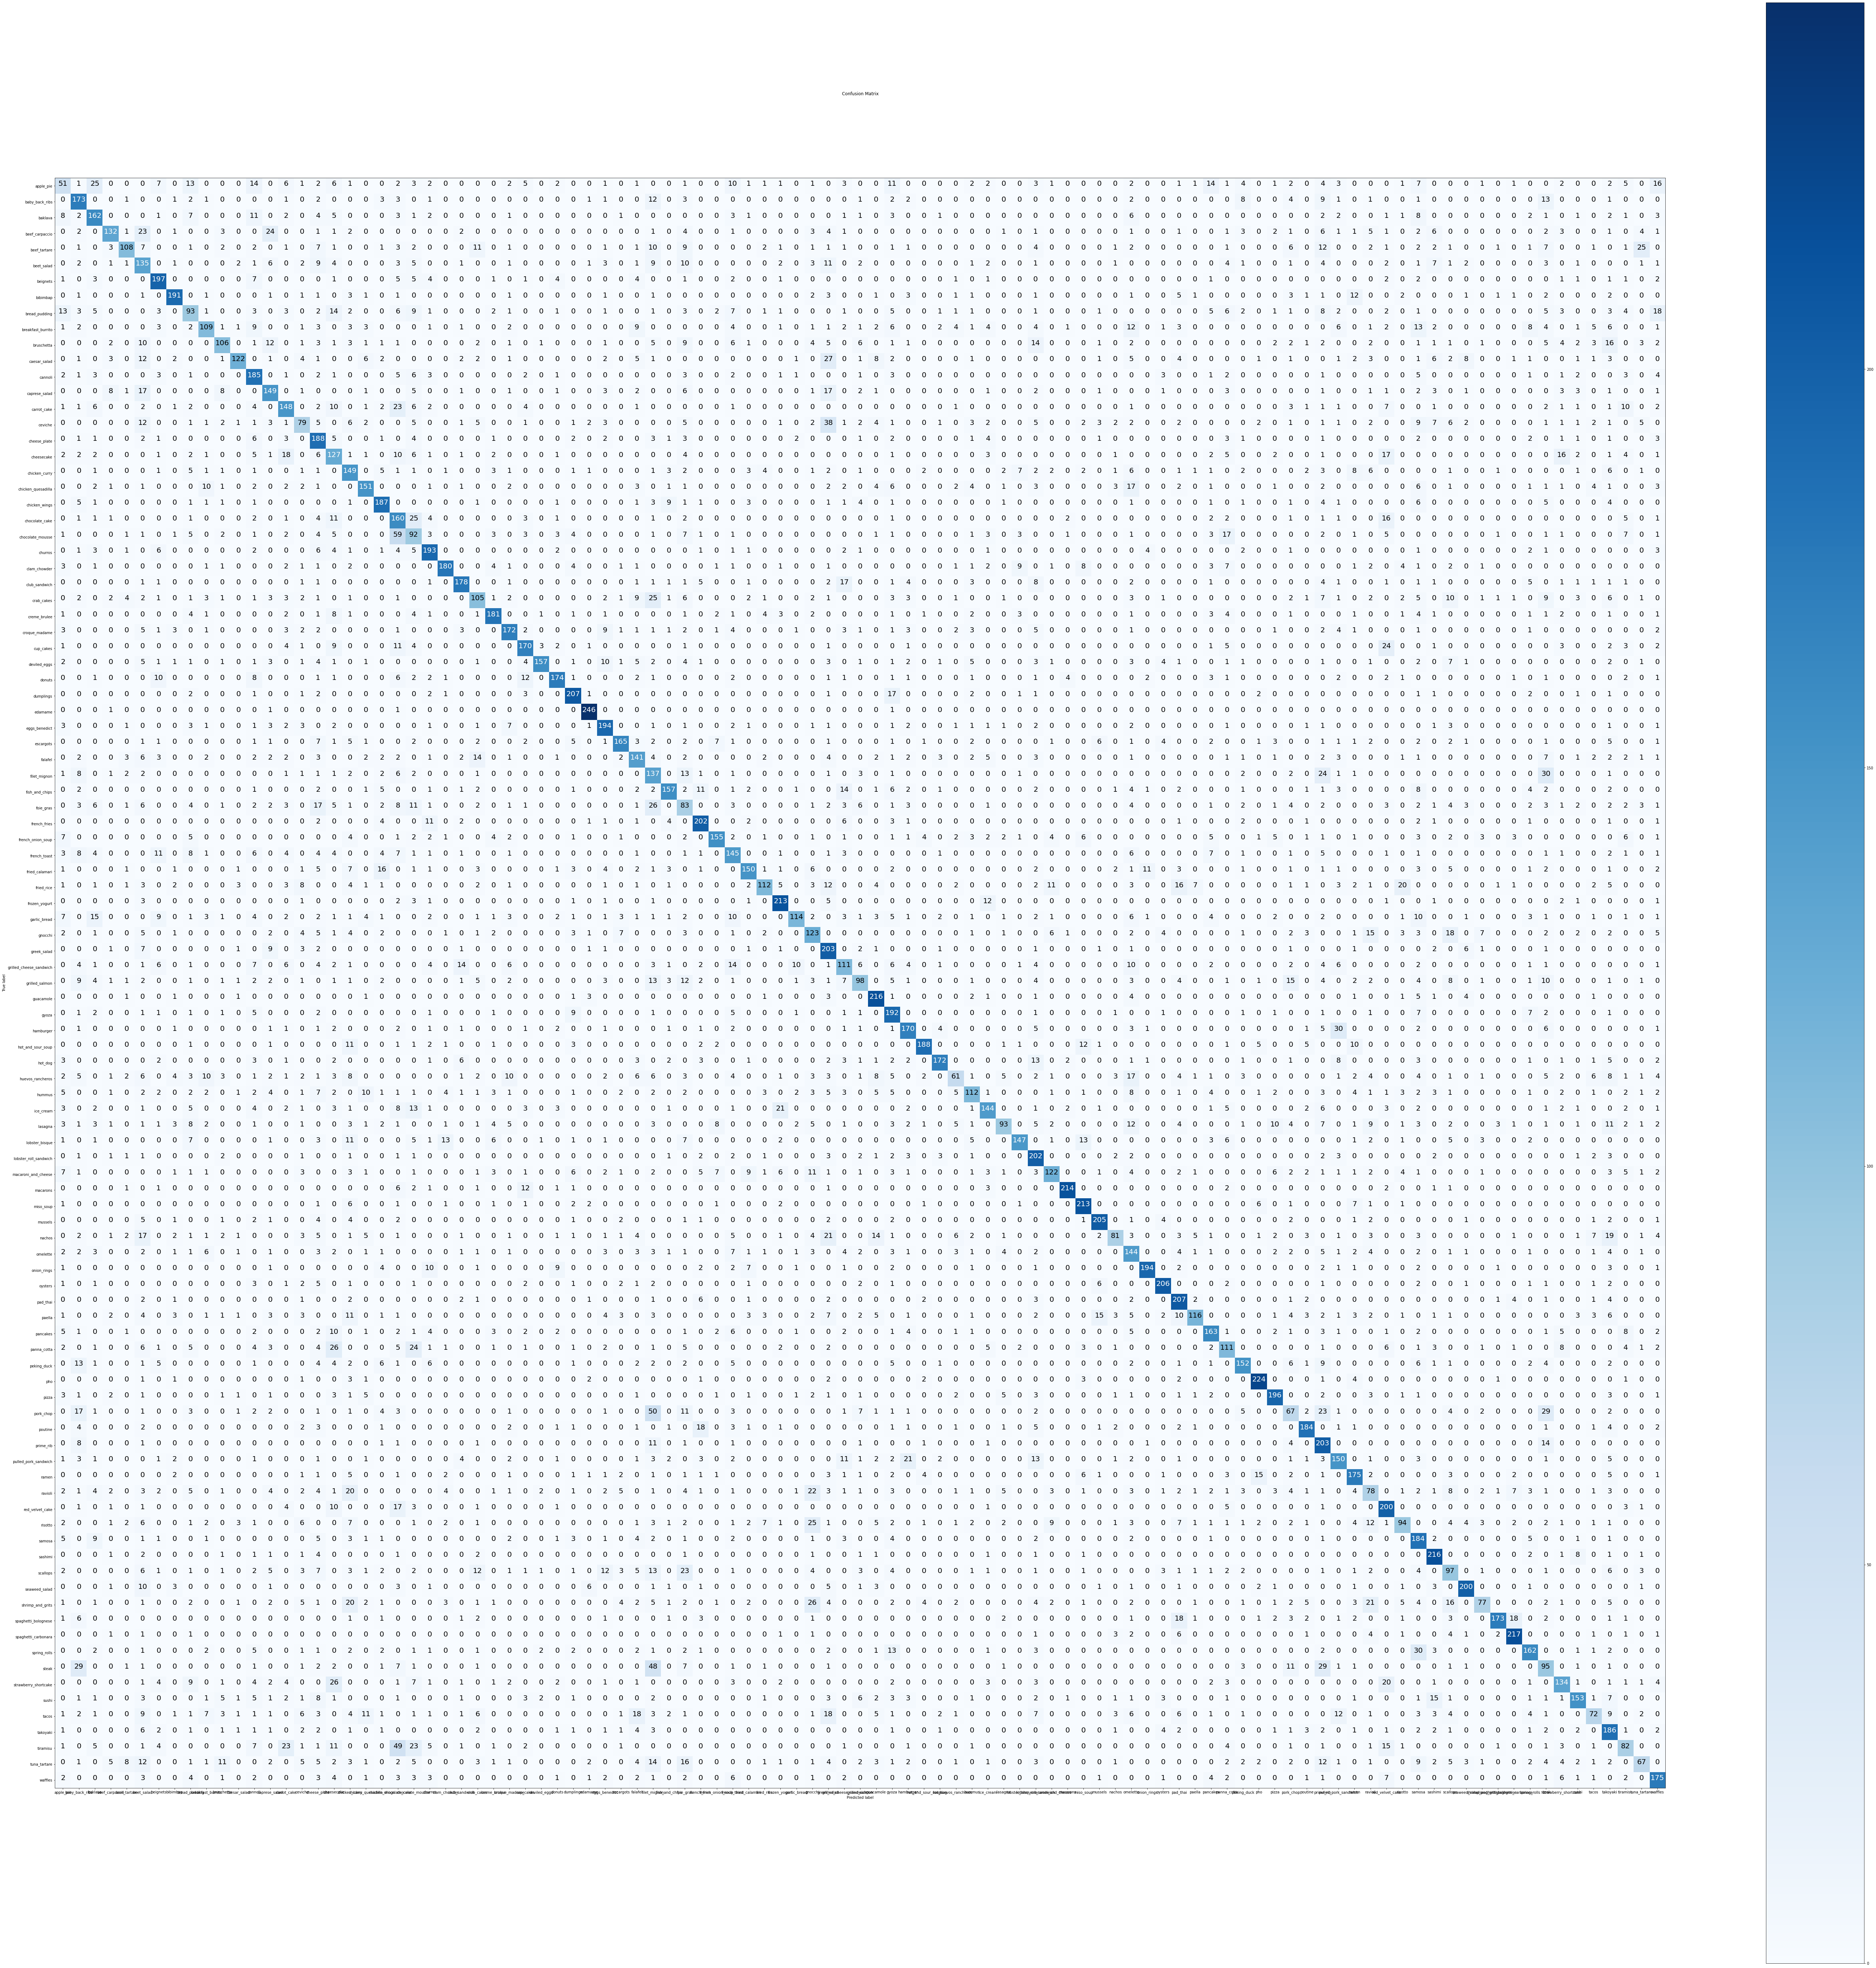

In [ ]:
make_confusion_matrix(y_true= y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [ ]:
# writing confusion_matrix code instead of using helper function
import itertools
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

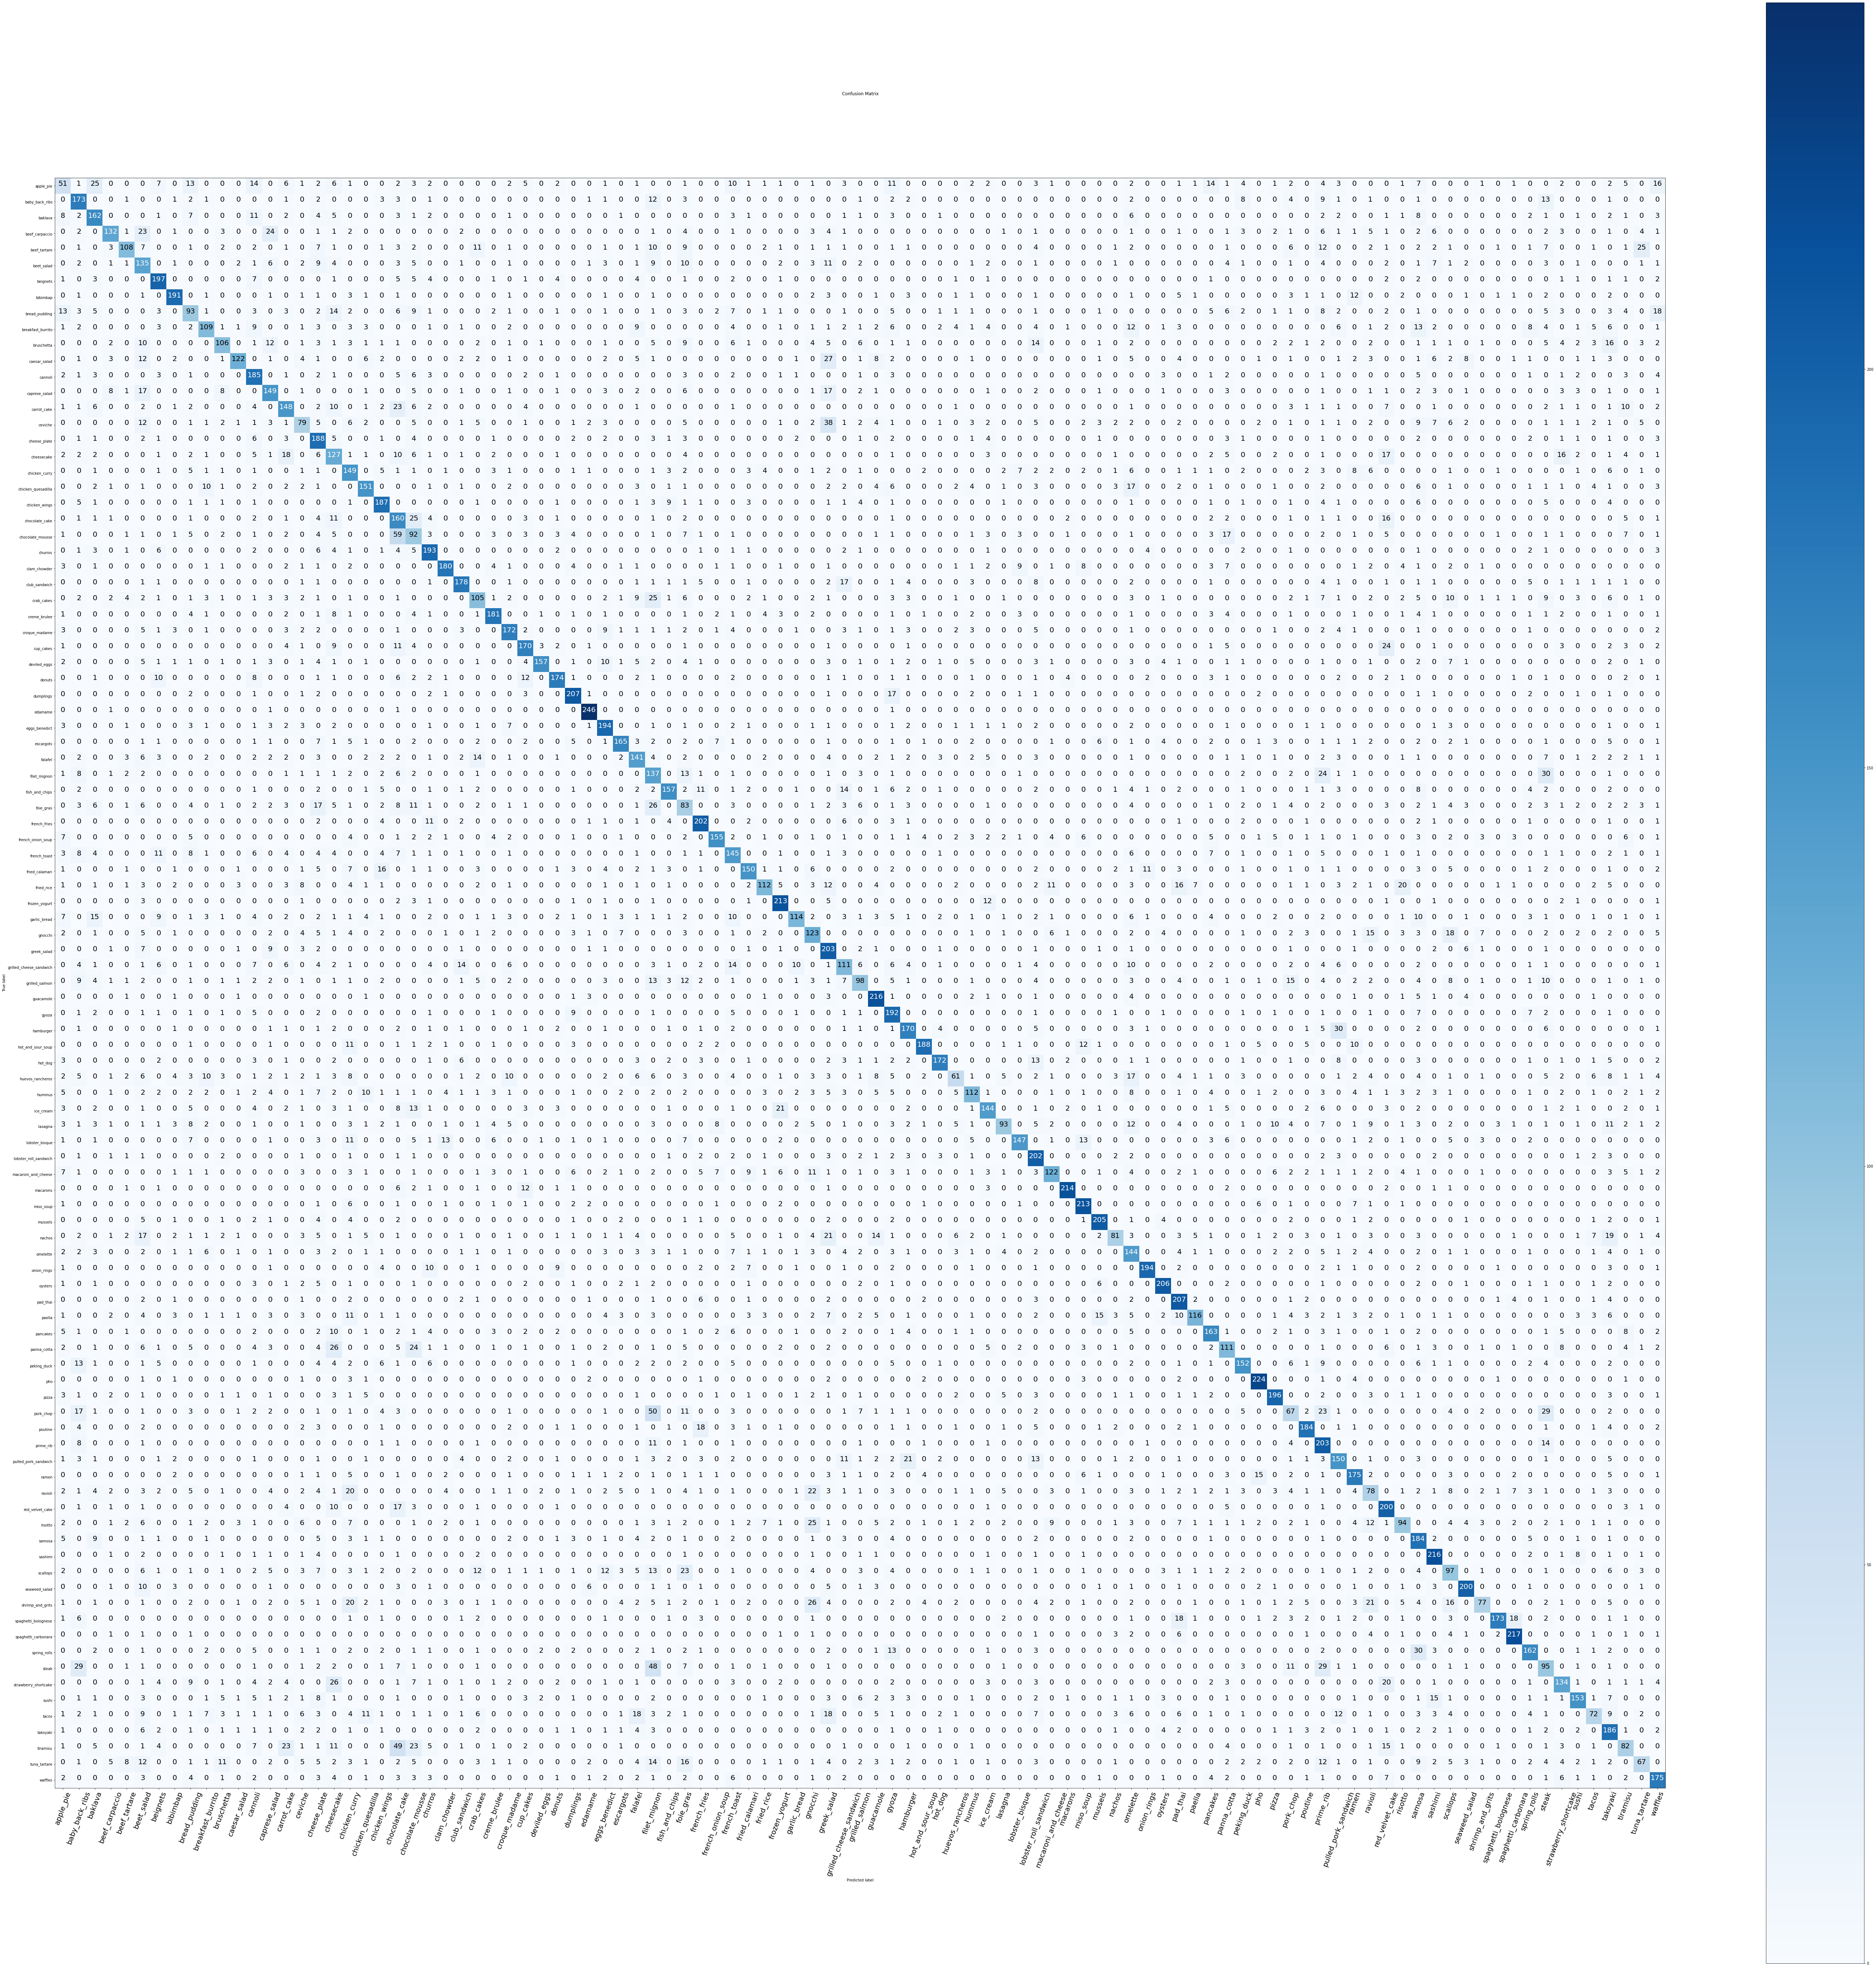

In [ ]:
make_confusion_matrix(y_true= y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

### classification report

- lets keep the  evaluation trtain going, time for classification report
- sklearn is a helpful function for aquiring many different classification metrics per classes (e.g precisoin, reacll, F1 score) called 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# making these number visualize
# making classification report as dict
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
classification_report_dict['77']['f1-score'] # 77 is class name and f1-score is the value want  to extract

0.30875576036866365

In [ ]:
# plotting all F1-score
class_f1_scores={} # creating another dict
for key, value in classification_report_dict.items():
  if key=='accuracy':
    break
  else:
    class_f1_scores[class_names[int(key)]] = value['f1-score']

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                         'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

f1_scores

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


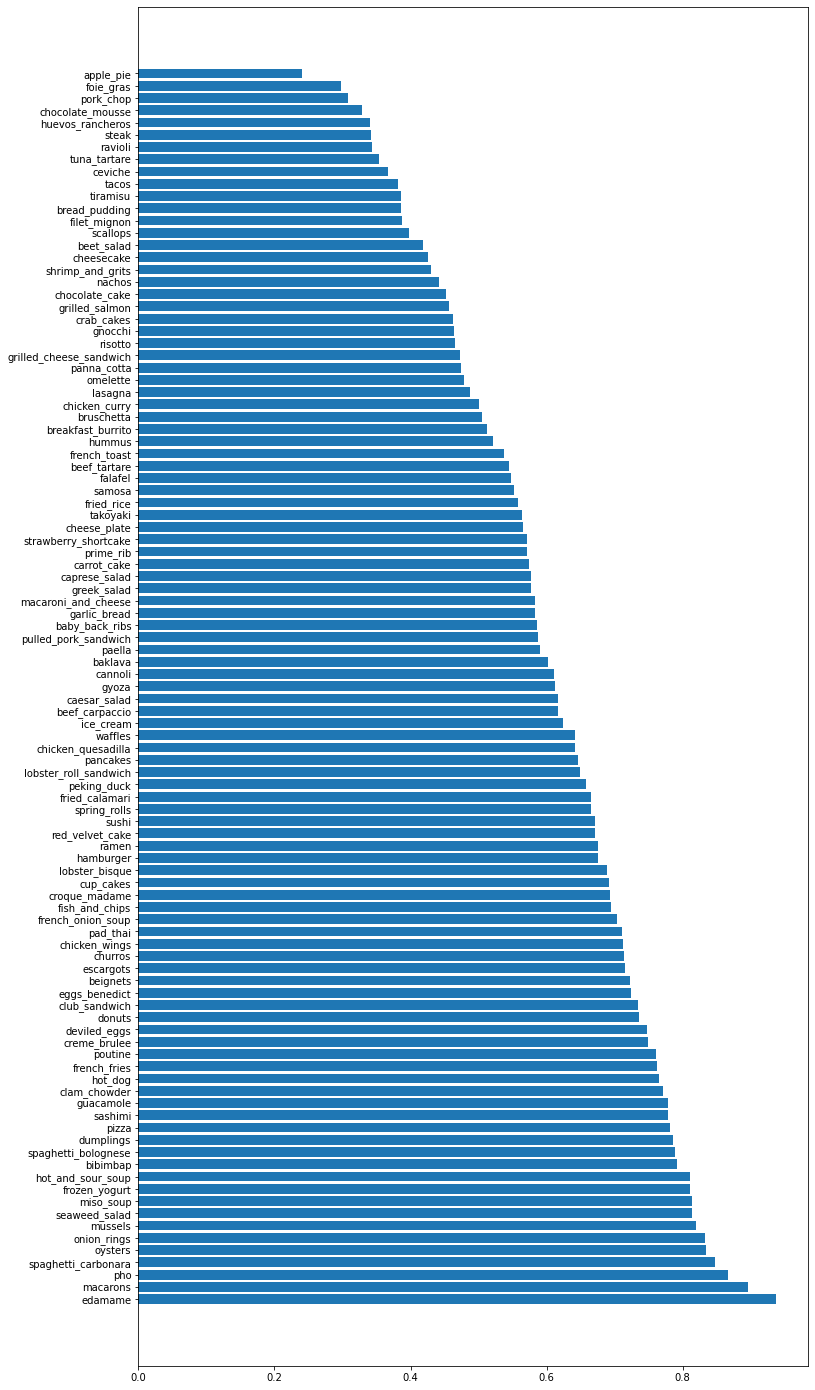

In [ ]:
import matplotlib.pyplot as plt


fig, ax=plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names']); # here comes the importance of symbol(;), if we dont put symbol 
                                              # first it dispaly text and class_names and then visualize 
ax.set_xlabel('F1-score')
ax.set_title('f1-score for data')
ax.invert_yaxis(); # reverse the order of our plot

# there are many design changes we can go with

In [ ]:
pred_classes 

array([ 52,   0,   0, ..., 100,  94, 100])

# visualizing prediction on real test data means on data that is not even in test data
- we need to create a function to load and preprocess data/ images
  - read target images filepath using tf.io.read_file()
  - turn images into tensors using tf.io.decode_images()
  - Resize images tensors to same size as the images our model has trained on using tf.image.resize()
  - scale the image to get all pixel values between 0 & 1


- PNG have 4 color channels. make sure which format we are daeling with. 

In [40]:
def load_and_pre_image(filename, img_shape=224, scale=True):

  '''
  Read an image convert inro tensors and reshape it into specified shape and color_iamge=3

  Args:
    filename(str): path to file name 
    scale: scalee pixel value frrom 0-255 to 0-1.

  Return:
    Image tensor to shape
    '''
    # read image
  img = tf.io.read_file(filename)

    # Decode image into tensors
  img= tf.io.decode_image(img, channels=3) # converting image into 3 chnnel from any number of channel

    # Resize the iamge
  img=tf.image.resize(img, [img_shape, img_shape])

    # scale 
  if scale:
      # rescale the image (get images between 0-1)
    return img/255.
  else:
    return img # don't need to rescale image in case of EfficientNet model


- we got code to load and prepare target image, let's visualize image, their target label and model's predicition
  - load random image frrom test data
  - make prediction on laoded image
  - plot the orginal image along with model's prediction, prediction probablility and truth label

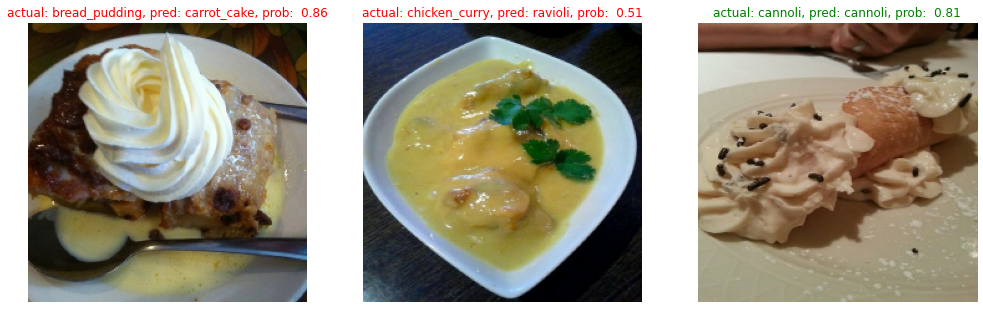

In [72]:
# make pred on series of random images
import os
import random
import matplotlib.pyplot as plt


plt.figure(figsize=(17, 10))
for i in range(3):
  # choose random image from random classes
  class_name = random.choice(class_names)
  filename= random.choice(os.listdir(test_dir + '/' +  class_name))
  filepath=test_dir + class_name + '/' + filename
  #print(filepath)

  # load the image and make predictions
  img = load_and_pre_image(filepath, scale=False)
  # print(img.shape) # for eficientNet it is False while for other mdoedl it will be True
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded)                  # get prediction probablilities array
  pred_class = class_names[pred_prob.argmax()]    # get highest prediction probablilities index and match with pred_class

  #print(pred_prob)
  #print(pred_class)

  # plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f'actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max(): .2f}', c=title_color)
  plt.axis(False);

In [ ]:
import random
random.choice(class_names)

- Finding where our model is most wrong, let's erite to find out following:
  -  Geta ll the imaes file path in test dataset using list_files() method
  - create pandas dataframe of imiage filepath, ground truth labels, predicted classes (from our model), max prediction probabilities, pred_class_names,ground truth class
  - use DataFrame t find all wrong prediction
  - sort the dataframe based on wrong prediction (have highest prediction prob prediction at top)
  - visualize the images with highest prediction probabilities but have wrong prediction.


In [73]:
# getting all the image file path in test dataset 
filepaths =[]
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg',
                                     shuffle=False): # pay attention to the astick mark
  filepaths.append(filepath.numpy())
len(filepaths)

25250

In [76]:
# create dataframe of different  parameter for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_conf': pred_prob.max(axis=1), # get max prediction prob value
                        'y_true_classnames': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})
pred_df

ValueError: ignored

In [71]:
print(len(filepaths))
print(len(y_labels))
print(len(pred_classes))
print(len(pred_prob))
print(len(class_names))

25250
25250
25250
1
101


In [ ]:
# find in our DataFrame which predictions are wrong
pred_df['pred_corrct'] = pred_df['y_true'] ==pred_df['y_pred']
pred_df.head()

In [ ]:
# sorting our Dataframe to have most wrong predictions at top
top_100_wrong = pred_df[pred_df['pred_correct']==False].sort_values('pred_conf', ascending=False)[:100]

In [ ]:
# to visualize testdata sample which have the wrong predictions but highest pred_probability
image_to_view=0
start_index = 0 # we can keep 10, 20 to show only10, 20 images
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+image_to_view].itertuple()):
  plt.subplot(3, 3, i+1)
  img=load_and_pre_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classnames, y_pred_classname, _, = row # only interested in a few parameter of each row
  plt.imshow(img/255.)
  plt.title(f'actual: {y_true_classnames}, pred:{y_pred_classname}, prob: {pred_prob}')
  plt.axis(False)

In [77]:
# test out big dog model on our own custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data('custom_food_images.zip')

--2021-10-04 15:38:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2021-10-04 15:38:29 (125 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [79]:
# get custom food images filepaths
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg']

In [ ]:
# make pred on and plot on cutsom data
for img in custom_food_images:
  img=load_and_pre_image(img, scale=False) # no need to scale for efficientNet
  pred_prob = model.predict(tf.expand_dims(img, axis = 0)) # make prediction on sameshape as trained [1,223, 334, 3]
  pred_class = class_names[pred_prob.argmax()]

  #plotting appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'pred: {pred_class}, prob: {pred_prob.max():.2f}')
  plt.axis(False)